In [1]:
#import keras
from IPython import get_ipython
get_ipython().magic('reset -sf') 

import nltk
import pandas as pd
import numpy as np
import re
import codecs
import gc
from nltk.corpus import wordnet
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pivottablejs import pivot_ui
import random 
from nltk.probability import FreqDist
import pickle

    

In [2]:
# Helper Functions

# Number of records to be written in the file for manual examination
sample_test_size=20
# which feature to focus for labeling 'all_tokens', 
imp_feature='product_type'
# number of records to process
max_record=1000000

def plot_class_distribution (data_frame, groupby_feature,class_name, starting_index=0):
    grouped  = data_frame.groupby([class_name]) 
    values=grouped[groupby_feature].agg(np.size)[starting_index:]  
    labels =  values.index.tolist()  
    y_pos = np.arange(len(labels))
    plt.bar(y_pos, values)
    plt.xticks(y_pos, labels)
    plt.xlabel('Product categories')
    plt.ylabel('Number of Products')
    plt.show()
    print(data_frame[class_name].value_counts())

#Lemmatize Normalization
def normalize (tokens):
    lem = WordNetLemmatizer()
    return [lem.lemmatize(token,pos=get_wordnet_pos(token)) for token in tokens]

#clean up  tokenized  data
def standardize_tokens (tokens):
    return [token.lower() for token in tokens]

#map NLTK’s POS tags
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# our categories and their related words
classes=['unisex', 'men', 'women', 'kid', 'baby']
manNet=['man','men', 'male', 'gentleman', 'gent','masculine',' manlike', ' mannish']
womanNet=['woman', 'women', 'lady', 'female' 'ladies', 'girl','feminine','unmacho','metrosexual' ]
babyNet= ['baby','toddler','infant', 'babe', 'bambino', 'infant', 'neonate', 'newborn']
kidNet=['kid','child', 'children', 'child', 'youth', 'joni','schoolchild', 'schoolgirl', 'schoolkid','junior']
unisexNet=['unisex','androgynous', 'genderless', 'unisexual']
all_Nets_list= [manNet,womanNet,babyNet,kidNet,unisexNet ]




In [3]:

dbfile = open('../data/labeled/labeled_dataV1-1million', 'rb')     
df= pickle.load(dbfile) 
dbfile.close() 

print(df.shape)
#df=df[0:max_record]


(1000000, 18)


In [4]:
#df=df2
df.head()

,product_type,vendor_name,title,store_domain,store_product_brand_domain,description,primary_price,full_store_product_url,all_text_original,vendor_name_original,all_tokens,all_text,unisex,men,women,baby,kid,class
0,[cookware],[hestan],"[hestan, nanobond, stainless, qtl, covered, sa...",[atlantagrillcompanycom],[hestanculinarycom],[nan],290.0,https://atlantagrillcompany.com/products/hesta...,Cookware Hestan Hestan Nanobond Stainless 3qt/...,hestan,"[cookware, hestan, hestan, nanobond, stainless...",cookware hestan hestan nanobond stainless qtl ...,0,0,0,0,0,-1
1,[cookware],[hestan],"[hestan, nanobond, titanium, stockpot, quart]",[atlantagrillcompanycom],[hestanculinarycom],[nan],450.0,https://atlantagrillcompany.com/products/hesta...,Cookware Hestan Hestan Nanobond Titanium Stock...,hestan,"[cookware, hestan, hestan, nanobond, titanium,...",cookware hestan hestan nanobond titanium stock...,0,0,0,0,0,-1
2,[skillets],[hestan],"[hestan, nanobond, , , open, skillet]",[dasallascom],[hestanculinarycom],[nan],189.95,https://dasallas.com/products/hestan-nanobond-...,"Skillets Hestan Hestan Nanobond 8.5"" Open Skil...",hestan,"[skillets, hestan, hestan, nanobond, , , open,...",skillets hestan hestan nanobond open skillet...,0,0,0,0,0,-1
3,"[saucepans, , sauciers]",[hestan],"[hestan, nanobond, quart, covered, essential, ...",[dasallascom],[hestanculinarycom],[nan],499.95,https://dasallas.com/products/hestan-nanobond-...,Saucepans & Sauciers Hestan Hestan Nanobond 5-...,hestan,"[saucepans, , sauciers, hestan, hestan, nanobo...",saucepans sauciers hestan hestan nanobond qua...,0,0,0,0,0,-1
4,[cookware],[hestan],"[hestan, probond, forged, stainless, steel, ul...",[atlantagrillcompanycom],[hestanculinarycom],[nan],799.99,https://atlantagrillcompany.com/products/hesta...,Cookware Hestan Hestan ProBond Forged Stainles...,hestan,"[cookware, hestan, hestan, probond, forged, st...",cookware hestan hestan probond forged stainles...,0,0,0,0,0,-1


#  Find records labeled in  round 1

In [5]:
#keep trackes of record labeled in this round
labeled_data_index_r1=df[df['class']!= '-1'].index.to_list()

print("Number of records labeled in round 1:", len(labeled_data_index_r1))
print("Number of records not labeled in round 1:",df.shape[0]-len(labeled_data_index_r1))

Number of records labeled in round 1: 33260
Number of records not labeled in round 1: 966740


## Round 2: Find the most common keywords in product information and label records containg those keywords


###  1) Define commmon keywords for each category

In [6]:
# if these keywords are in the product information and the product is not labeled so far, can be used to label the 
#products
unisexProduct= ['electronics', 'phone','fruit','movie','vegetable', 
                'seafood','ipad','video','music','book', 'dairy',
                'egg', 'fridge', 'phone', 'supplement', 'cable', 
                'cookware', 'cook', 'novel', 'bike','headphone',
               'appliance','battery', 'vitamin','fence', 'garden',
                'speaker','camera', 'kitchen', 'radio', 'backpack'
                'frozen', 'food', 'household', 'safety','sex toys' ,'skate', 'tuna', 'home' ]

womanProduct=['jewellery', 'pregnancy', 'make up', 'nail polish', 
              'eye shadow', 'skirt','Manicure', 'Pedicure', 'jewellery', 'bracelet', 'necklace',
              'earring', 'jewelry', 'lingerie'  ]

menProduct= ['shave', 'tuxedo'] 


kidProduct=['school', 'disney', 'spider', 'barbie','doll'  ]

babyProduct=['Pacifier' ,'Strollers', 'diapers', 'potty', 'walkers',
             'playmat',  'Car Seat', 'lip liner', 'Babyliss', 'maternity', 
             'Teether', 'nursery', 'carrier', 'crib', 'Rattle', 'sleeper']




#lemmitize and standardize the all the categories lists
unisexProduct=normalize(unisexProduct)
unisexProduct=standardize_tokens(unisexProduct)
menProduct=normalize(menProduct)
menProduct=standardize_tokens(menProduct)
womanProduct=normalize(womanProduct)
womanProduct=standardize_tokens(womanProduct)
kidProduct=normalize(kidProduct)
kidProduct=standardize_tokens(kidProduct) 
babyProduct=normalize(babyProduct)
babyProduct=standardize_tokens(babyProduct) 

all_categories_lists=[unisexProduct,   menProduct ,  womanProduct ,  kidProduct ,  babyProduct]
all_keyword_lists= all_Nets_list+all_categories_lists

all_keyword_set= set()
for list_a in all_keyword_lists:
    #all_keyword_set = all_keyword_set.union(set(list_a))
    all_keyword_set.update(set(list_a))
    



### 2) Find most commmon words in product information which are not included in the categories lists

####   Let's inspect word and vocabulary of our data set

In [7]:
df["all_tokens"]



0         [cookware, hestan, hestan, nanobond, stainless...
1         [cookware, hestan, hestan, nanobond, titanium,...
2         [skillets, hestan, hestan, nanobond, , , open,...
3         [saucepans, , sauciers, hestan, hestan, nanobo...
4         [cookware, hestan, hestan, probond, forged, st...
                                ...                        
999995    [grapes, mbg, south, africa, autumn, crisp, se...
999996    [stone, fruits, mbg, premium, canada, cherry, ...
999997    [mix, , match, mbg, mbg, mix, , match, combo, ...
999998    [seasonal, fruits, mbg, thailand, king, lychee...
999999    [apples, pears, mbg, korea, cherry, apple, , g...
Name: all_tokens, Length: 1000000, dtype: object

In [8]:

#combine all rows' tokens  into one list
#all_words=list([a for b in df[imp_feature].tolist() for a in b])
all_words=list([a for b in df['product_type'] for a in b])
all_words=list(filter(lambda a: a not in [',', '(', ')', "'", '"', ' ', "'s", 'nan'], all_words))


In [9]:
#Find the most frequent words which are not included  categories lists
fdist = FreqDist(all_words)
for word,number in fdist.most_common(30):
    if word not in all_keyword_set:
        print (word, end = ', ')

    

, accessories, tops, clothing, top, earrings, dress, shoes, dresses, shirts, tshirt, bags, covers, apparel, ring, card, decor, toys, de, watch, mobile, shirt, watches, pants, 

#### None of these keywords can help us to label more products. so, let's move to  label the records based on our selected common keywords

### 3) Label records containg common keywords

In [10]:
#find the total frequency of a list of keywords in a tokenized list 
def count_occurance_keyword ( tokenized_list, category_list ) :
        count=0
        text_data= ' '.join( tokenized_list)+" "
        for keyword in category_list:
                count = text_data.count(keyword+" ") 
        return count     
    
def findLabel_commonKeywords(dataFrame, feature): 
    count_unisex = count_occurance_keyword(dataFrame[feature], unisexProduct) 
    count_men   =  count_occurance_keyword(dataFrame[feature], menProduct) 
    count_woman  = count_occurance_keyword(dataFrame[feature], womanProduct) 
    count_kid    = count_occurance_keyword(dataFrame[feature], kidProduct) 
    count_baby   = count_occurance_keyword(dataFrame[feature], babyProduct) 
    
    index=['unisex', 'men', 'women', 'kid', 'baby']
    counters=[count_unisex, count_men, count_woman,count_kid,count_baby]
    frequency= pd.Series(counters, index=index)
    
    # find label with maximum frequency
    max_frequency= max(frequency)
    max_label= frequency.idxmax() if max_frequency> 0 else '-1' 
    return max_label


#notLabled = df[ df['class'] == '-1' ]  
not_labled_index=  df['class'] == '-1' 
df.loc[not_labled_index, 'class'] = df.loc[not_labled_index,:].apply(findLabel_commonKeywords, axis=1,args=[imp_feature]) 



In [11]:
#Ignore thi line, just to test funstion
#count_occurance_keyword(['tie','men', 'baby', 'shaver','shaves', 'tie','shave', 'tiered'], ['tie', 'shave']) 

#  Find records labeled in  round 2

In [12]:
#keep trackes of record labeled in this round
labeled_data_index=df[df['class']!= '-1'].index.to_list()
print(len(labeled_data_index))
labeled_data_index_r2 = [i for i in labeled_data_index if i not in labeled_data_index_r1]
print(len(labeled_data_index_r2))

print("Number of records labeled in round 2:", len(labeled_data_index_r2))
print("Number of records not labeled yet:",df.shape[0]-len(labeled_data_index))

43335
10075
Number of records labeled in round 2: 10075
Number of records not labeled yet: 956665


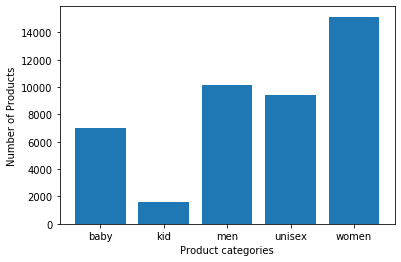

-1        956665
women      15149
men        10173
unisex      9416
baby        6996
kid         1601
Name: class, dtype: int64


In [13]:
plot_class_distribution (df, 'product_type','class', starting_index=1)

# Export Labeled Data

In [14]:

df.to_csv("../data/labeled/labeled_dataV2-1million.csv", index=True) 
 
dbfile = open('../data/labeled/labeled_dataV2-1million', 'wb')      
pickle.dump(df, dbfile) 
dbfile.close() 

##  Choose some random records that are labeled in this round in order to check the labeling performance

In [15]:
random_records=random.sample(labeled_data_index_r2, k=sample_test_size) 
test=df.loc[random_records, ['class','product_type','full_store_product_url' ,'all_text_original']]
test.to_csv("../data/validate/test_random_labeled_data_Round2-1million.csv", index=True)

#  Round 3: Labeling more records based on vendor names

If products from a vendor all belong to one particular category (given that at least 10 products are listed), we can assign that category to other products from the same vendor

In [16]:
#pivot_ui(labeled_data )

In [17]:
homo_brands= {}
labeled_data=df[df['class']!= '-1'].copy()
grouped  = labeled_data.groupby(['vendor_name_original'])
for key, group in grouped:
   class_group = grouped.get_group(key).groupby(['class']) 
   #print(key, len(class_group ), class_group['class'].count() )
   # if all products belong to one category
   if len(class_group)==1:
      # If at least 10 products are listed for a company
      if  (class_group['class'].count()[0]) > 10 :
         homo_brands[key]= list(class_group.groups.keys())[0]

print(homo_brands)

{'&tradition': 'unisex', '08 left': 'unisex', '1st new zealand': 'women', '665 inc': 'men', 'aakaa': 'women', 'african artwork': 'unisex', 'aikyou': 'women', 'aldi': 'baby', 'amazello': 'unisex', 'an an londree': 'women', 'an ink in twine': 'baby', 'ann taylor loft': 'women', 'anna beck': 'women', 'aromatique': 'unisex', 'ash candles': 'unisex', 'aytm': 'unisex', 'baa stool': 'unisex', 'babbi shoes': 'women', 'baby banana': 'baby', "baby k'tan": 'baby', 'baby ktan': 'baby', 'balloons and weights': 'baby', 'bamboom': 'baby', 'barbara bologna': 'women', 'bear camp': 'baby', 'blacksaw': 'unisex', 'blissoma': 'men', 'block design': 'unisex', 'bodycology': 'women', 'brownlow gifts': 'unisex', 'buckaroo': 'unisex', 'cadolle': 'women', 'camco': 'unisex', 'canada for victory': 'women', 'carry me ph': 'women', 'casa carta': 'unisex', 'chaos & harmony': 'women', 'chic pipsqueak': 'women', 'cinnamon projects': 'unisex', 'cire trudon': 'unisex', 'claire burke': 'unisex', 'cloud 9 childrenswear': '

In [18]:
homo_vendor_bool=  df['vendor_name_original'].apply( lambda x: x in list(homo_brands.keys())) 
not_labled_bool=   df['class'] == '-1'
#records which are not labeled yet and belong to homo vendor
homo_notLabeld_bool=np.logical_and(not_labled_bool, homo_vendor_bool)
homo_notLabeld_index= df[homo_notLabeld_bool].index

pd.DataFrame({'homo_vendor': homo_vendor_bool, 'not_labled_bool': not_labled_bool,'homo_notLabeld_bool':homo_notLabeld_bool  })
display(df) 

,product_type,vendor_name,title,store_domain,store_product_brand_domain,description,primary_price,full_store_product_url,all_text_original,vendor_name_original,all_tokens,all_text,unisex,men,women,baby,kid,class
0,[cookware],[hestan],"[hestan, nanobond, stainless, qtl, covered, sa...",[atlantagrillcompanycom],[hestanculinarycom],[nan],290.0,https://atlantagrillcompany.com/products/hesta...,Cookware Hestan Hestan Nanobond Stainless 3qt/...,hestan,"[cookware, hestan, hestan, nanobond, stainless...",cookware hestan hestan nanobond stainless qtl ...,0,0,0,0,0,-1
1,[cookware],[hestan],"[hestan, nanobond, titanium, stockpot, quart]",[atlantagrillcompanycom],[hestanculinarycom],[nan],450.0,https://atlantagrillcompany.com/products/hesta...,Cookware Hestan Hestan Nanobond Titanium Stock...,hestan,"[cookware, hestan, hestan, nanobond, titanium,...",cookware hestan hestan nanobond titanium stock...,0,0,0,0,0,-1
2,[skillets],[hestan],"[hestan, nanobond, , , open, skillet]",[dasallascom],[hestanculinarycom],[nan],189.95,https://dasallas.com/products/hestan-nanobond-...,"Skillets Hestan Hestan Nanobond 8.5"" Open Skil...",hestan,"[skillets, hestan, hestan, nanobond, , , open,...",skillets hestan hestan nanobond open skillet...,0,0,0,0,0,-1
3,"[saucepans, , sauciers]",[hestan],"[hestan, nanobond, quart, covered, essential, ...",[dasallascom],[hestanculinarycom],[nan],499.95,https://dasallas.com/products/hestan-nanobond-...,Saucepans & Sauciers Hestan Hestan Nanobond 5-...,hestan,"[saucepans, , sauciers, hestan, hestan, nanobo...",saucepans sauciers hestan hestan nanobond qua...,0,0,0,0,0,-1
4,[cookware],[hestan],"[hestan, probond, forged, stainless, steel, ul...",[atlantagrillcompanycom],[hestanculinarycom],[nan],799.99,https://atlantagrillcompany.com/products/hesta...,Cookware Hestan Hestan ProBond Forged Stainles...,hestan,"[cookware, hestan, hestan, probond, forged, st...",cookware hestan hestan probond forged stainles...,0,0,0,0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,[grapes],[mbg],"[south, africa, autumn, crisp, seedless, green...",[mbgcommy],[mbgcommy],[nan],39.9,https://mbg.com.my/products/south-africa-autum...,Grapes MBG South Africa Autumn Crisp Seedless ...,mbg,"[grapes, mbg, south, africa, autumn, crisp, se...",grapes mbg south africa autumn crisp seedless ...,0,0,0,0,0,-1
999996,"[stone, fruits]",[mbg],"[premium, canada, cherry, , kgwoodencrate, ]",[mbgcommy],[mbgcommy],[nan],99.9,https://mbg.com.my/products/premium-canada-che...,Stone Fruits MBG Premium Canada Cherry (1KG/Wo...,mbg,"[stone, fruits, mbg, premium, canada, cherry, ...",stone fruits mbg premium canada cherry kgwood...,0,0,0,0,0,-1
999997,"[mix, , match]",[mbg],"[mbg, mix, , match, combo, , blueberry, , gree...",[mbgcommy],[mbgcommy],[nan],24.9,https://mbg.com.my/products/mbg-mix-match-comb...,Mix & Match MBG MBG Mix & Match Combo - Bluebe...,mbg,"[mix, , match, mbg, mbg, mix, , match, combo, ...",mix match mbg mbg mix match combo blueberry...,0,0,0,0,0,-1
999998,"[seasonal, fruits]",[mbg],"[thailand, king, lychee, , kgpack, ]",[mbgcommy],[mbgcommy],[nan],11.9,https://mbg.com.my/products/thailand-king-lych...,Seasonal Fruits MBG Thailand King Lychee (1KG/...,mbg,"[seasonal, fruits, mbg, thailand, king, lychee...",seasonal fruits mbg thailand king lychee kgpa...,0,0,0,0,0,-1


In [19]:
print("not labeled \n",df[not_labled_bool].index)
print("homo \n",df[homo_vendor_bool].index)
print("homo and notlabeled \n",df[homo_notLabeld_bool].index)


not labeled 
 Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            999990, 999991, 999992, 999993, 999994, 999995, 999996, 999997,
            999998, 999999],
           dtype='int64', length=956665)
homo 
 Int64Index([  2143,   2144,   2145,   2146,   2147,   2148,   2149,   2150,
              2151,   2152,
            ...
            999201, 999202, 999203, 999204, 999205, 999206, 999207, 999208,
            999209, 999210],
           dtype='int64', length=89283)
homo and notlabeled 
 Int64Index([  2143,   2144,   2145,   2146,   2147,   2148,   2149,   2150,
              2151,   2152,
            ...
            999201, 999202, 999203, 999204, 999205, 999206, 999207, 999208,
            999209, 999210],
           dtype='int64', length=77364)


In [20]:
def get_homo_class ( x ):
    vendor=x['vendor_name_original']
    #print(vendor, homo_brands[vendor])
    return homo_brands[vendor]
    
df.loc[homo_notLabeld_index, 'class'] = df.loc[homo_notLabeld_index,:].apply(get_homo_class, axis=1)


#  Find records labeled in round 3

In [21]:
#keep trackes of record labeled in this round
labeled_data_index=df[df['class']!= '-1'].index.to_list()
print(len(labeled_data_index))
labeled_data_index_before=labeled_data_index_r1+labeled_data_index_r2
labeled_data_index_r3 = [i for i in labeled_data_index if i not in labeled_data_index_before]
print(len(labeled_data_index_r3))

120699
77364


In [22]:


print("Number of records labeled in round 3:", len(labeled_data_index_r3))
print("Number of records not labeled yet:",df.shape[0]-len(labeled_data_index))

Number of records labeled in round 3: 77364
Number of records not labeled yet: 879301


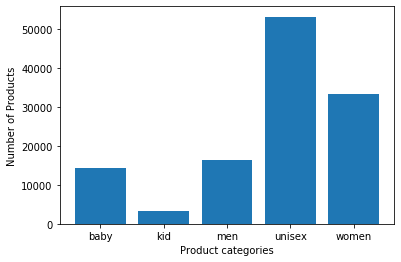

-1        879301
unisex     53272
women      33463
men        16441
baby       14261
kid         3262
Name: class, dtype: int64


In [23]:
plot_class_distribution (df, 'product_type','class', starting_index=1)

# Export Labeled Data

In [24]:

df.to_csv("../data/labeled/labeled_dataV3-1million.csv", index=True)
 
dbfile = open('../data/labeled/labeled_dataV3-1million', 'wb')      
pickle.dump(df, dbfile) 
dbfile.close() 

In [25]:
display(labeled_data.head())

,product_type,vendor_name,title,store_domain,store_product_brand_domain,description,primary_price,full_store_product_url,all_text_original,vendor_name_original,all_tokens,all_text,unisex,men,women,baby,kid,class
122,"[children, formulas]","[trace, minerals, research]","[concentrace, kid, trace, mineral, , oz]",[vitaminpartnerscom],[tracemineralscom],[nan],21.53,https://vitaminpartners.com/products/concentra...,Children's Formulas Trace Minerals Research Co...,trace minerals research,"[children, formulas, trace, minerals, research...",children formulas trace minerals research conc...,0,0,0,0,1,kid
764,"[apparel, , unisex, accessories]",[orbea],"[orca, speed, laces]",[allsportscom],[orbeacom],[nan],7.99,https://all3sports.com/products/orca-speed-laces,Apparel - Unisex Accessories Orbea Orca Speed ...,orbea,"[apparel, , unisex, accessories, orbea, orca, ...",apparel unisex accessories orbea orca speed l...,1,0,0,0,0,unisex
1002,"[apparel, , unisex, accessories]",[orbea],"[orca, new, speed, laces]",[allsportscom],[orbeacom],[nan],7.99,https://all3sports.com/products/orca-new-speed...,Apparel - Unisex Accessories Orbea Orca NEW Sp...,orbea,"[apparel, , unisex, accessories, orbea, orca, ...",apparel unisex accessories orbea orca new spe...,1,0,0,0,0,unisex
1444,"[children, books, , comics, , graphic, novels]","[viz, media, llc]","[hikaru, go, , vol, , ]",[roninbookcouk],[vizcom],[nan],11.66,https://roninbook.co.uk/products/9781421510668...,Children's Books>Comics & Graphic Novels VIZ M...,viz media llc,"[children, books, , comics, , graphic, novels,...",children books comics graphic novels viz med...,0,0,0,0,1,kid
1844,"[home, products]",[snom],"[amplifier, announcements, , ohm, ]",[techboyca],[snomcom],[nan],221.99,https://techboy.ca/products/amplifier-announce...,Home Products Snom Amplifier Announcements ove...,snom,"[home, products, snom, amplifier, announcement...",home products snom amplifier announcements oh...,0,0,0,0,0,unisex


##  Choose some random records that are labeled in this round in order to check the labeling performance

In [26]:
random_records=random.sample(labeled_data_index_r3, k=sample_test_size) 
test=df.loc[random_records, ['class','product_type','full_store_product_url' ,'all_text_original']]
test.to_csv("../data/validate/test_random_labeled_data_Round3-1million.csv", index=True)



In [27]:
df


,product_type,vendor_name,title,store_domain,store_product_brand_domain,description,primary_price,full_store_product_url,all_text_original,vendor_name_original,all_tokens,all_text,unisex,men,women,baby,kid,class
0,[cookware],[hestan],"[hestan, nanobond, stainless, qtl, covered, sa...",[atlantagrillcompanycom],[hestanculinarycom],[nan],290.0,https://atlantagrillcompany.com/products/hesta...,Cookware Hestan Hestan Nanobond Stainless 3qt/...,hestan,"[cookware, hestan, hestan, nanobond, stainless...",cookware hestan hestan nanobond stainless qtl ...,0,0,0,0,0,-1
1,[cookware],[hestan],"[hestan, nanobond, titanium, stockpot, quart]",[atlantagrillcompanycom],[hestanculinarycom],[nan],450.0,https://atlantagrillcompany.com/products/hesta...,Cookware Hestan Hestan Nanobond Titanium Stock...,hestan,"[cookware, hestan, hestan, nanobond, titanium,...",cookware hestan hestan nanobond titanium stock...,0,0,0,0,0,-1
2,[skillets],[hestan],"[hestan, nanobond, , , open, skillet]",[dasallascom],[hestanculinarycom],[nan],189.95,https://dasallas.com/products/hestan-nanobond-...,"Skillets Hestan Hestan Nanobond 8.5"" Open Skil...",hestan,"[skillets, hestan, hestan, nanobond, , , open,...",skillets hestan hestan nanobond open skillet...,0,0,0,0,0,-1
3,"[saucepans, , sauciers]",[hestan],"[hestan, nanobond, quart, covered, essential, ...",[dasallascom],[hestanculinarycom],[nan],499.95,https://dasallas.com/products/hestan-nanobond-...,Saucepans & Sauciers Hestan Hestan Nanobond 5-...,hestan,"[saucepans, , sauciers, hestan, hestan, nanobo...",saucepans sauciers hestan hestan nanobond qua...,0,0,0,0,0,-1
4,[cookware],[hestan],"[hestan, probond, forged, stainless, steel, ul...",[atlantagrillcompanycom],[hestanculinarycom],[nan],799.99,https://atlantagrillcompany.com/products/hesta...,Cookware Hestan Hestan ProBond Forged Stainles...,hestan,"[cookware, hestan, hestan, probond, forged, st...",cookware hestan hestan probond forged stainles...,0,0,0,0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,[grapes],[mbg],"[south, africa, autumn, crisp, seedless, green...",[mbgcommy],[mbgcommy],[nan],39.9,https://mbg.com.my/products/south-africa-autum...,Grapes MBG South Africa Autumn Crisp Seedless ...,mbg,"[grapes, mbg, south, africa, autumn, crisp, se...",grapes mbg south africa autumn crisp seedless ...,0,0,0,0,0,-1
999996,"[stone, fruits]",[mbg],"[premium, canada, cherry, , kgwoodencrate, ]",[mbgcommy],[mbgcommy],[nan],99.9,https://mbg.com.my/products/premium-canada-che...,Stone Fruits MBG Premium Canada Cherry (1KG/Wo...,mbg,"[stone, fruits, mbg, premium, canada, cherry, ...",stone fruits mbg premium canada cherry kgwood...,0,0,0,0,0,-1
999997,"[mix, , match]",[mbg],"[mbg, mix, , match, combo, , blueberry, , gree...",[mbgcommy],[mbgcommy],[nan],24.9,https://mbg.com.my/products/mbg-mix-match-comb...,Mix & Match MBG MBG Mix & Match Combo - Bluebe...,mbg,"[mix, , match, mbg, mbg, mix, , match, combo, ...",mix match mbg mbg mix match combo blueberry...,0,0,0,0,0,-1
999998,"[seasonal, fruits]",[mbg],"[thailand, king, lychee, , kgpack, ]",[mbgcommy],[mbgcommy],[nan],11.9,https://mbg.com.my/products/thailand-king-lych...,Seasonal Fruits MBG Thailand King Lychee (1KG/...,mbg,"[seasonal, fruits, mbg, thailand, king, lychee...",seasonal fruits mbg thailand king lychee kgpa...,0,0,0,0,0,-1


In [28]:
random_records=random.sample(labeled_data_index_r3, k=sample_test_size) 
test=df.loc[random_records, ['class','product_type','full_store_product_url' ,'all_text_original']]
test.to_csv("../data/validate/test_random_labeled_data_Round3-1million.csv", index=True)